# Get the Rating Matrix

In [54]:
# pip install apyori

  Using cached apyori-1.1.2.tar.gz (8.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=45509ad2f75569b24f80b3c4d52cb665c7ce7a6cf6beca34e8e71761667ee3ad
  Stored in directory: c:\users\melih.kacaman\appdata\local\pip\cache\wheels\1a\4d\4f\a171c142b66180456b83a6180a70e68108127ea2d546ca174b
Successfully built apyori
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip install mlxtend  


In [4]:
#!pip install efficient-apriori

In [1]:
import pandas as pd 
data_with_3 = pd.read_csv("../datasets/ratings_with_3_combinations_reduced.csv")[["rating", "bill"]]

data_with_3.head()

,rating,bill
0,1,"(745321, 666652)"
1,12,"(772494, 754574)"
2,1,"(772494, 745328)"
3,11,"(772494, 749358)"
4,1,"(772494, 745310)"


In [2]:
data_3_greater_1 = data_with_3[data_with_3.rating > 1] 

data_3_greater_1.head() 

,rating,bill
1,12,"(772494, 754574)"
3,11,"(772494, 749358)"
5,6,"(754574, 745328)"
6,23,"(754574, 749358)"
7,7,"(754574, 745310)"


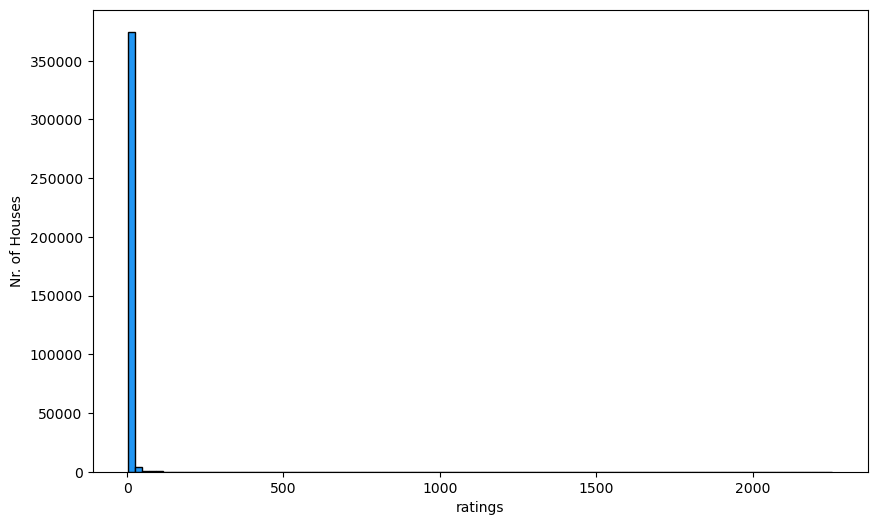

In [3]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

In [8]:
max(data_3_greater_1.rating),  min(data_3_greater_1.rating)

(2255, 2)

c:\Users\melih.kacaman\Anaconda3\envs\MF_project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

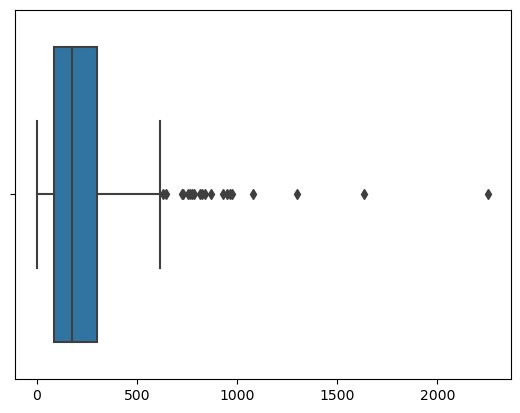

In [9]:
import seaborn as sns
sns.boxplot(data_3_greater_1['rating'].unique())

In [4]:
import numpy as np
data_3_greater_1_log = data_3_greater_1.copy() 
data_3_greater_1_log["rating"] = np.log(data_3_greater_1.rating) 

data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [5]:
max(data_3_greater_1_log.rating),  min(data_3_greater_1_log.rating)

(7.720905251936779, 0.6931471805599453)

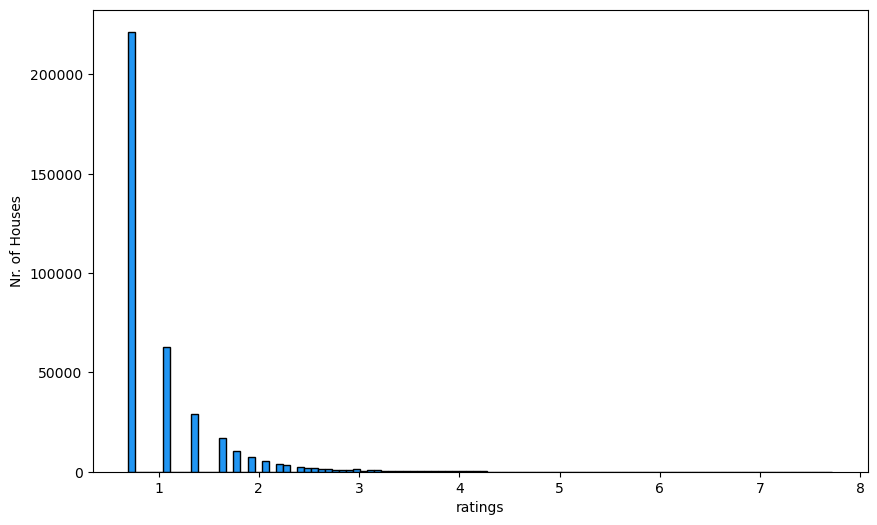

In [6]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1_log['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

c:\Users\melih.kacaman\Anaconda3\envs\MF_project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

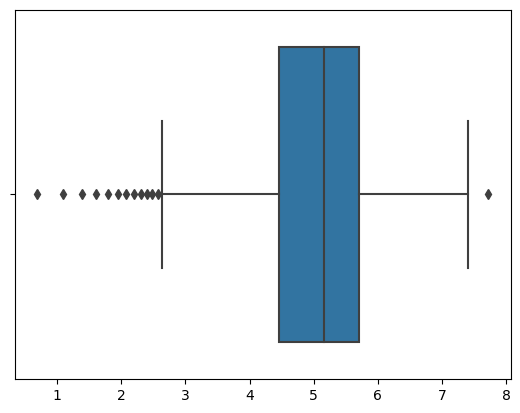

In [7]:
import seaborn as sns
sns.boxplot(data_3_greater_1_log['rating'].unique())

In [8]:
import numpy as np 
Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_3_greater_1_log['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("data_3_greater_1_log has IQR:", IQR) 

data_3_greater_1_log has IQR: 0.6931471805599453


C:\Users\melih.kacaman\AppData\Local\Temp\ipykernel_17908\1636379702.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
C:\Users\melih.kacaman\AppData\Local\Temp\ipykernel_17908\1636379702.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data_3_greater_1_log['rating'], 75,


In [9]:
import pandas as pd
data_raw = pd.read_csv("../datasets/raw_data.csv") 

In [16]:
data_raw.head() 

,Unnamed: 0,optionId,bill
0,0,751839,1
1,1,751782,1
2,2,745321,1
3,3,666652,1
4,4,751873,2


In [10]:
transactions = [] 

bill = 1
option_bill = [] 

for index,row in data_raw.iterrows(): 
    if(row.bill == bill):
        option_bill.append(row.optionId)
    else:
        bill = row.bill 
        transactions.append(tuple(set(option_bill))) 
        option_bill.clear()
        option_bill.append(row.optionId)  


transactions[:3]

[(745321, 666652, 751782, 751839),
 (751873, 760125),
 (772494, 754574, 745328, 749358, 745310)]

# Model 1: Matrix Factorization Using Keras 

#### Data Prep for MF 

In [18]:
data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [19]:
from ast import literal_eval

data_3_greater_1_log.bill = data_3_greater_1_log.bill.apply(literal_eval) 
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380442 entries, 1 to 4492451
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  380442 non-null  float64
 1   bill    380442 non-null  object 
dtypes: float64(1), object(1)
memory usage: 8.7+ MB


In [20]:
type(data_3_greater_1_log.bill.iat[0])

tuple

In [21]:
statement = (772494, 754574, 749358) 
s_set = set(statement) 
tuple(s_set.difference([772494]))

(749358, 754574)

In [22]:
def split_bill(statement):
    return [
        (tuple(set(statement).difference([statement[0]])), statement[0]),
        (tuple(set(statement).difference([statement[1]])), statement[1]),
        (tuple(set(statement).difference([statement[2]])), statement[2])
    ]

In [23]:
data_3_greater_1_log["option_count"] = data_3_greater_1_log.bill.apply(lambda x: len(x))
data_3_greater_1_log.tail() 

,rating,bill,option_count
4490148,0.693147,"(774694, 767718, 767721)",3
4490843,0.693147,"(774590, 774319)",2
4490847,0.693147,"(774469, 774590, 774319)",3
4491087,0.693147,"(764896, 786771, 774571)",3
4492451,0.693147,"(748899, 748868, 752949)",3


In [24]:
sublist_by_2 = data_3_greater_1_log[data_3_greater_1_log.option_count == 2]

In [25]:
sublist_by_2_concat = pd.concat([
    sublist_by_2,
    pd.DataFrame(data_3_greater_1_log[data_3_greater_1_log.option_count == 2].bill.to_list(), columns=["LHS", "RHS"], index=sublist_by_2.index)
], axis=1)
sublist_by_2_concat.head()

,rating,bill,option_count,LHS,RHS
1,2.484907,"(772494, 754574)",2,772494,754574
3,2.397895,"(772494, 749358)",2,772494,749358
5,1.791759,"(754574, 745328)",2,754574,745328
6,3.135494,"(754574, 749358)",2,754574,749358
7,1.945910,"(754574, 745310)",2,754574,745310


In [26]:
sublist_by_3 = data_3_greater_1_log[data_3_greater_1_log.option_count == 3]
sublist_by_3.head() 

,rating,bill,option_count
12,0.693147,"(772494, 754574, 749358)",3
18,0.693147,"(754574, 745328, 745310)",3
34,1.098612,"(751649, 751591, 751532)",3
35,0.693147,"(751649, 751591, 751597)",3
36,0.693147,"(751649, 751595, 751532)",3


In [27]:
replicated_rows = pd.DataFrame(np.repeat(sublist_by_3.values, 3, axis=0), columns=sublist_by_3.columns)

sublists_by_3_reduced = []  
for item in sublist_by_3.bill.to_list():
    sublists_by_3_reduced += split_bill(item) 

sublists_by_3_reduced = pd.DataFrame(sublists_by_3_reduced, columns=["LHS", "RHS"])

sublist_by_3_concat = pd.concat([
    replicated_rows, 
    sublists_by_3_reduced
], axis=1)

sublist_by_3_concat.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [28]:
dataset_combined_MF = pd.concat([sublist_by_3_concat, sublist_by_2_concat], axis=0, ignore_index=True)
dataset_combined_MF.head()  

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [29]:
dataset_combined_MF.option_count.unique() 

array([3, 2], dtype=object)

In [30]:
sublist_by_2_concat["LHS_C"] = sublist_by_2_concat.LHS.astype('category').cat.codes.values
sublist_by_2_concat["RHS_C"] = sublist_by_2_concat.RHS.astype('category').cat.codes.values

sublist_by_2_concat.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1,2.484907,"(772494, 754574)",2,772494,754574,4116,3329
3,2.397895,"(772494, 749358)",2,772494,749358,4116,2675
5,1.791759,"(754574, 745328)",2,754574,745328,3303,2414
6,3.135494,"(754574, 749358)",2,754574,749358,3303,2675
7,1.945910,"(754574, 745310)",2,754574,745310,3303,2403


In [31]:
len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())

(4800, 4764)

## Building MF Model 

### Model: With 2's Combine 

In [32]:
from tensorflow import keras
from keras.optimizers import Adam 

n_rhs, n_lhs = len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 

model = keras.Model([lhs_input, rhs_input], product) 


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 rhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lhs-embeddings (Embedding)     (None, 1, 20)        95300       ['lhs-item[0][0]']               
                                                                                                  
 rhs-embeddings (Embedding)     (None, 1, 20)        96020       ['rhs-item[0][0]']               
                                                                                              

In [34]:
initial_weights = model.get_weights()

In [35]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(sublist_by_2_concat[["RHS_C", "LHS_C"]], sublist_by_2_concat.rating, test_size=0.10) 
X_train[:5], y_train[:5]

(        RHS_C  LHS_C
 755351   3106   3074
 64353     895   3104
 228967   3680   3530
 216991   2669   3973
 98534    3702   3678,
 755351    0.693147
 64353     2.397895
 228967    2.197225
 216991    0.693147
 98534     0.693147
 Name: rating, dtype: float64)

In [36]:
len(X_train.RHS_C.unique()), len(X_test.RHS_C.unique())

(4723, 3027)

In [37]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3, )

In [ ]:
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    verbose=0,
    callbacks=[early_stopping]
)

In [ ]:
sublist_by_2_concat.rating.max(), sublist_by_2_concat.rating.min() 

(7.720905251936779, 0.6931471805599453)

In [ ]:
model.get_layer(name='lhs-embeddings').get_weights()

[array([[-0.02177034,  0.1481692 , -0.03187216, ...,  0.10407609,
         -0.10500072,  0.10895164],
        [-0.06736637,  0.392427  , -0.3087096 , ...,  0.4726055 ,
         -0.264871  ,  0.2945564 ],
        [-0.3110728 ,  0.06170886, -0.3974962 , ..., -0.01603061,
          0.34502065,  0.2788888 ],
        ...,
        [-0.36481744, -0.20177539, -0.01978035, ..., -0.21235523,
         -0.1260905 ,  0.35021508],
        [-0.20204706, -0.56822234, -0.25336036, ...,  0.09620483,
         -0.198949  ,  0.20911638],
        [ 0.03746461,  0.04933782, -0.01811503, ..., -0.01224027,
          0.04905355, -0.00313085]], dtype=float32)]

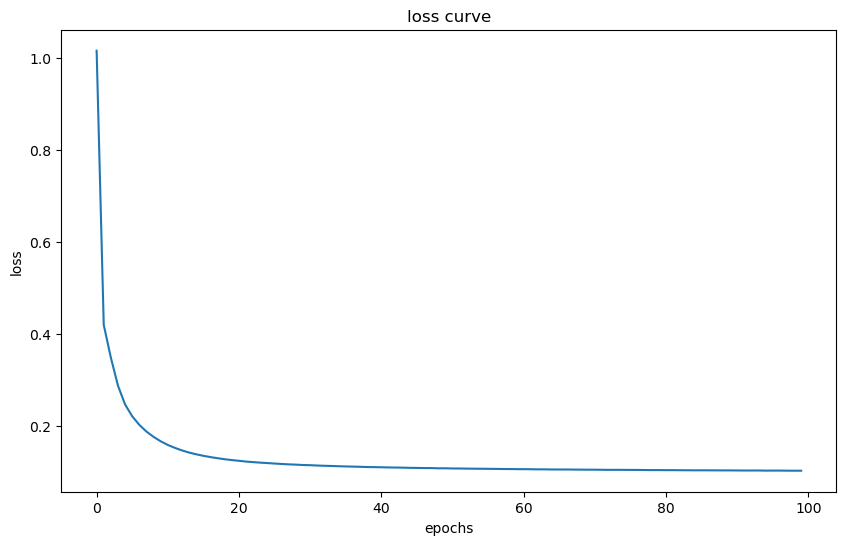

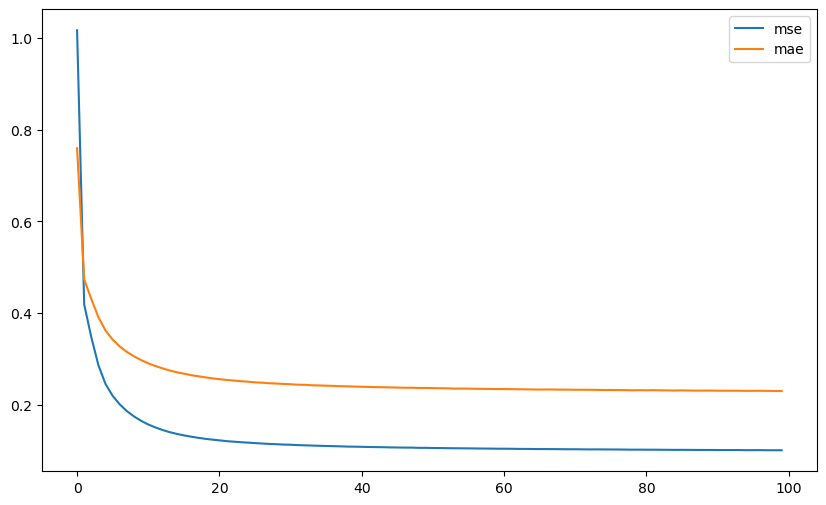

In [ ]:
import matplotlib.pyplot as plt 

plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
pd.DataFrame(history.history)[["mse", "mae"]].plot(figsize=(10,6))
plt.show() 

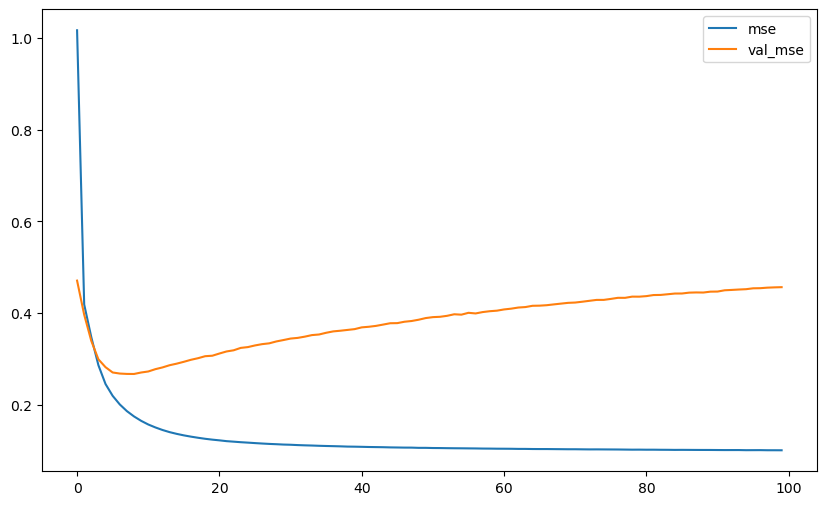

In [ ]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

In [ ]:
model.set_weights(initial_weights)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
5959/5959 [==============================] - 14s 2ms/step - loss: 1.0122 - mae: 0.7568 - mse: 1.0122 - val_loss: 0.4577 - val_mae: 0.4950 - val_mse: 0.4577
Epoch 2/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.4013 - mae: 0.4637 - mse: 0.4013 - val_loss: 0.3738 - val_mae: 0.4489 - val_mse: 0.3738
Epoch 3/100
5959/5959 [==============================] - 13s 2ms/step - loss: 0.3301 - mae: 0.4199 - mse: 0.3301 - val_loss: 0.3303 - val_mae: 0.4248 - val_mse: 0.3303
Epoch 4/100
5959/5959 [==============================] - 13s 2ms/step - loss: 0.2848 - mae: 0.3901 - mse: 0.2848 - val_loss: 0.3033 - val_mae: 0.4092 - val_mse: 0.3033
Epoch 5/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.2497 - mae: 0.3651 - mse: 0.2497 - val_loss: 0.2859 - val_mae: 0.3988 - val_mse: 0.2859
Epoch 6/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.2235 - mae: 0.3455 - mse: 0.2235 - val_loss: 0.2757 - val_mae: 0.3936 - val_mse:

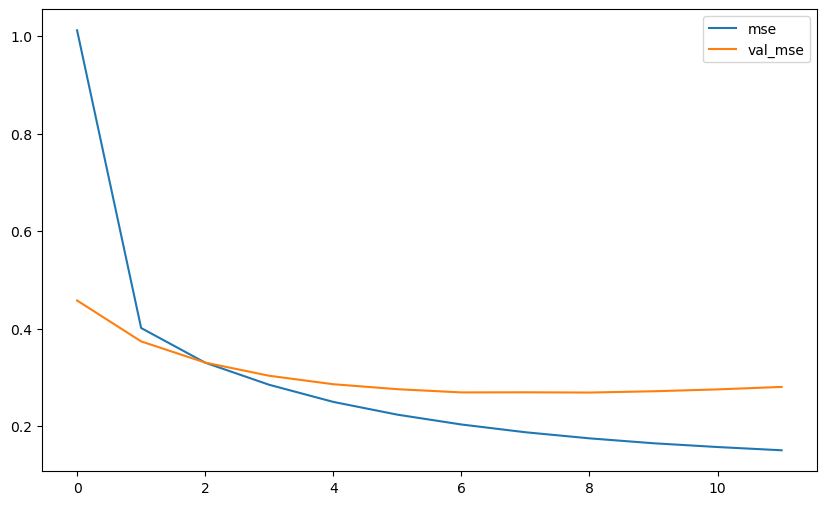

In [ ]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

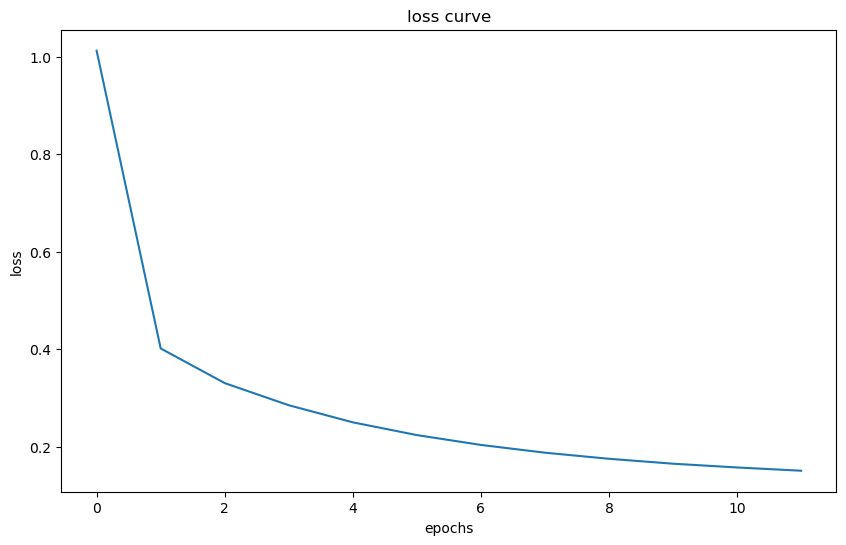

In [ ]:
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
plt.show() 

In [ ]:
lhs_embddings = model.get_layer(name='lhs-embeddings').get_weights()[0]
lhs_embddings

array([[ 0.07672624,  0.1441114 , -0.09079949, ...,  0.07186385,
        -0.16795698,  0.09694991],
       [ 0.36516654,  0.321668  , -0.3316731 , ...,  0.34359965,
        -0.31315002,  0.1143278 ],
       [-0.3908737 ,  0.3245383 , -0.42838246, ..., -0.16936451,
         0.39514837,  0.3617861 ],
       ...,
       [-0.15693542, -0.28883344, -0.30711654, ...,  0.1990875 ,
        -0.29604653,  0.17519644],
       [-0.07308272, -0.07753923, -0.19093463, ..., -0.08352129,
        -0.2572938 ,  0.1935987 ],
       [ 0.03746461,  0.04933782, -0.01811503, ..., -0.01224027,
         0.04905355, -0.00313085]], dtype=float32)

In [ ]:
rhs_embddings = model.get_layer(name='rhs-embeddings').get_weights()[0]
rhs_embddings

array([[-0.33580846,  0.28519332, -0.3303691 , ..., -0.21861579,
         0.29853255,  0.27347258],
       [ 0.21327884,  0.40882003, -0.31144893, ...,  0.18045461,
        -0.29885417,  0.38172802],
       [ 0.08428351, -0.11401626, -0.13879527, ..., -0.12634122,
         0.12098593,  0.0948944 ],
       ...,
       [-0.11605994, -0.14220591, -0.21202563, ...,  0.11994679,
        -0.14743006,  0.22444765],
       [-0.10582097, -0.06351969, -0.11116377, ...,  0.00681472,
        -0.17477284,  0.16025454],
       [-0.03401883,  0.02679673,  0.04624983, ...,  0.01432499,
        -0.00554911,  0.04062836]], dtype=float32)

In [ ]:
def recommend(option_in_category, number_of_options=5):
  options = lhs_embddings[option_in_category]@rhs_embddings.T
  mids = np.argpartition(options, -number_of_options)[-number_of_options:]
  
  return mids

In [ ]:
sublist_by_2_concat.LHS.value_counts()[:20]

753600    1066
753376    1048
753350     779
753536     745
753509     718
751600     698
753609     693
753517     604
759397     592
751526     584
753572     572
760352     544
748802     541
746304     508
753314     502
753507     497
670176     493
749920     485
760353     482
764515     476
Name: LHS, dtype: int64

In [ ]:
sublist_by_2_concat[sublist_by_2_concat.LHS == 759397].head()     # RHS = 721495, LHS = 751839

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1010,1.386294,"(759397, 753355)",2,759397,753355,3491,3049
1011,4.844187,"(759397, 753357)",2,759397,753357,3491,3051
1012,2.397895,"(759397, 755827)",2,759397,755827,3491,3386
1013,2.197225,"(759397, 753301)",2,759397,753301,3491,3017
1014,5.187386,"(759397, 753433)",2,759397,753433,3491,3088


In [ ]:
id_list = recommend(
    3678,
    10
)

sublist_by_2_concat.query("RHS_C in @id_list").RHS.unique() 

array([753517, 751581, 768374, 760332, 767741, 745226, 753350, 741126,
       786487, 733924], dtype=int64)

In [52]:
id_list

array([2938, 2517, 2452, 2372, 2228, 2349, 3986, 3096, 2244, 1637],
      dtype=int64)

### Model.2 : With 3's Combine  

It is moved to the notebook which is Model 2 Improving

# Model 2: Apriori (apyori Module)

In [11]:
from apyori import apriori

In [12]:
associations = apriori(
    transactions,
    min_length = 2,
    max_length=4,
    min_support = 0.0001,
    min_confidence = 0.0001,
    min_lift = 0.0001,
)

associations = list(associations)
len(associations)

8374

In [13]:
association = associations[100]
print(association)
print("support", association.support)
print(association.ordered_statistics)
print("right", association.ordered_statistics[0].items_add)
print("left", association.ordered_statistics[0].items_base)
print("confidence", association.ordered_statistics[0].confidence)
print("lift", association.ordered_statistics[0].lift)


RelationRecord(items=frozenset({635458}), support=0.0007728733714453959, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)])
support 0.0007728733714453959
[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)]
right frozenset({635458})
left frozenset()
confidence 0.0007728733714453959
lift 1.0


In [16]:
associations[0]

RelationRecord(items=frozenset({525099}), support=0.0045452314939764945, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099}), confidence=0.0045452314939764945, lift=1.0)])

In [17]:
rules = [] 
for association in associations:
    if len(association.ordered_statistics) > 1: 
        rules.append(association)

In [21]:
rules[0].ordered_statistics 

[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 525100}), confidence=0.0011010378585273694, lift=1.0),
 OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({525100}), confidence=0.24224021592442646, lift=11.800967554677243),
 OrderedStatistic(items_base=frozenset({525100}), items_add=frozenset({525099}), confidence=0.05363812938891378, lift=11.800967554677243)]

In [22]:
rules[1]

RelationRecord(items=frozenset({525099, 701998}), support=0.00010734352381186054, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 701998}), confidence=0.00010734352381186054, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({701998}), confidence=0.023616734143049933, lift=4.914089258293739), OrderedStatistic(items_base=frozenset({701998}), items_add=frozenset({525099}), confidence=0.022335673261008295, lift=4.914089258293739)])

In [23]:
rules[2]

RelationRecord(items=frozenset({702418, 525099}), support=0.0003066957823196015, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({702418, 525099}), confidence=0.0003066957823196015, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({702418}), confidence=0.06747638326585695, lift=8.972707839368782), OrderedStatistic(items_base=frozenset({702418}), items_add=frozenset({525099}), confidence=0.040783034257748776, lift=8.972707839368782)])